In [3]:
# Import statements - run this cell first
import json
import numpy as np
import requests
import os
import matplotlib.pyplot as plt
import random
import math
import re
from scipy.stats import anderson
from dotenv import load_dotenv
from datetime import datetime
load_dotenv()

/Users/alexc/Desktop/UofG/Final_Project/FinalProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


True

In [4]:
# Get the distribution of the github repositories by the number of commits
# Only consider Java repositories with 1000+ stars
# Only count the number of commits for the default branch
        # https://gist.github.com/0penBrain/7be59a48aba778c955d992aa69e524c5 - curl command to get the number of commits for the default branch
        # https://stackoverflow.com/questions/37602893/github-search-limit-results - way to go around the 1000 results limit on the github api

def get_top_java_repositories(repositories_dict=None, starsFrom=1000):     
    if repositories_dict is None:
        repositories_dict = {}

    try:
        total_count = 10000
        while total_count > 1: # Github api only allows 1000 results, regardless of the number of pages => need to add created from date to get all of them
            page = 1
            while (page - 1) * 100 < total_count and page < 11: # 1000 results limit
                # Make request to search for Java repositories with 1000+ stars
                print(f"GIT API Request with stars from: {starsFrom}")
                req = f'https://api.github.com/search/repositories?q=language:java stars:>={starsFrom}&per_page=100&sort=stars&order=asc&page={page}'
                print(req)
                response = requests.get(req, headers={'Authorization': f'Bearer {os.getenv("GITHUB_API_KEY")}'})
                response.raise_for_status()
                
                data = response.json()
                total_count = data['total_count']
                repositories = data['items']

                # Iterate through each repository on the page and create a dictionary entry for it if its not present
                for repo in repositories:
                    if repo['id'] in repositories_dict:
                        print(repositories_dict[repo['id']]['created_at'], repositories_dict[repo['id']]['stars'])
                        continue
                    repositories_dict[repo['id']] = {
                        'name': repo['name'],
                        'owner': repo['owner']['login'],
                        'created_at': repo['created_at'],
                        'stars' : repo['stargazers_count'],
                        'url' : repo['clone_url'],
                        'main_branch': repo['default_branch'],
                    }
                    print(f"Repository added: {repo['id']}, Name: {repo['name']}, Owner: {repo['owner']['login']}")

                maxStars = repositories[-1]['watchers']
                print(f"Page {page} done")
                page += 1
            starsFrom = maxStars
            print(f"Inner while done; Total count: {total_count}, Max stars: {starsFrom}")
    except requests.exceptions.RequestException as e:
        print("Error:", e)
    
    print("All repositories done; Total count:", len(repositories_dict))
    return repositories_dict, starsFrom

# loop throught the pages and get the commits
def populate_repositories_with_commits(repositories_dict):
    try:
        for repo in repositories_dict:
            if 'commitCount' in repositories_dict[repo]:
                continue
            owner = repositories_dict[repo]['owner']
            repo_name = repositories_dict[repo]['name']
            commits_url = f"https://api.github.com/repos/{owner}/{repo_name}/commits?per_page=1"

            # Make request to get commits for the repository
            commits_response = requests.get(commits_url, headers={'Authorization': f'Bearer {os.getenv("GITHUB_API_KEY")}'})
            commits_response.raise_for_status()

            # Extract page number from Link header
            link_header = commits_response.headers.get('Link', '')
            commit_count = extract_commit_count(link_header)
            repositories_dict[repo]['commitCount'] = commit_count
            print(f"Repository: {repo_name}, Owner: {owner}, Commit Count: {commit_count}")
        return repositories_dict
    except requests.exceptions.RequestException as e:
        print("Error:", e)
        return repositories_dict

def extract_commit_count(link_header):
    # Extracts the page number from the Link header using regex
    try:
        match = re.search(r'&page=(\d+)>; rel="last"', link_header)
        if match:
            return int(match.group(1))
    except AttributeError:
        return None
    return None

In [5]:
# get the repositories
def get_high_star_repositories():
    repositories_all = {}
    if os.path.exists('../data/high_star_repositories.json'):
        with open('../data/high_star_repositories.json', 'r') as json_file:
            repositories_all = json.load(json_file)
    else:
        repositories_all, max_stars = get_top_java_repositories()
        with open('../data/high_star_repositories.json', 'w') as json_file:
            json.dump(repositories_all, json_file, indent=4)
    return repositories_all

# get the repositories with commit count
def get_high_star_repositories_with_commitCount():
    repositories_with_commitCount = {}
    if os.path.exists('../data/high_star_repositories_with_commitCount.json'):
        with open('../data/high_star_repositories_with_commitCount.json', 'r') as json_file:
            repositories_with_commitCount = json.load(json_file)
    else:
        repositories = get_high_star_repositories()
        repositories_with_commitCount = populate_repositories_with_commits(repositories)
        with open('../data/high_star_repositories_with_commitCount.json', 'w') as json_file:
            json.dump(repositories_with_commitCount, json_file, indent=4)
    return repositories_with_commitCount

In [6]:
def get_all_files_in_path(path):
    all_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            all_files.append(file_path)
    print(all_files)

os.path.exists('../data/')

True

In [7]:
populated_repos = get_high_star_repositories_with_commitCount()

In [8]:
list_of_repos = list(populated_repos.values())

# repos by created at date
repos_by_date = sorted(list_of_repos, key=lambda x: datetime.strptime(x['created_at'],"%Y-%m-%dT%H:%M:%SZ"), reverse=True)

# repos by stars
repos_by_stars = sorted(list_of_repos, key=lambda x: x['stars'], reverse=True)

# repos by commit count
repos_by_commit_count = sorted(list_of_repos, key=lambda x: x['commitCount'], reverse=True)

In [12]:

repos_after_cutoff = [repo for repo in repos_by_commit_count if datetime.strptime(repo['created_at'], "%Y-%m-%dT%H:%M:%SZ") > datetime.strptime("2021-10-01T00:00:00Z", "%Y-%m-%dT%H:%M:%SZ")]
sorted_repos_after_cutoff = sorted(repos_after_cutoff, key=lambda x: x['stars'], reverse=True)
print(f"There is {len(repos_after_cutoff)} repos that were created after the cut-off")

for repo in repos_after_cutoff:
    print(repo["name"])
    print(repo["url"])
    print(repo["created_at"])

There is 102 repos that were created after the cut-off
TV
https://github.com/FongMi/TV.git
2022-06-22T09:10:23Z
fastjson2
https://github.com/alibaba/fastjson2.git
2022-04-17T04:27:24Z
mastodon-android
https://github.com/mastodon/mastodon-android.git
2022-01-14T10:44:03Z
conductor
https://github.com/conductor-oss/conductor.git
2023-12-08T06:06:09Z
Chat2DB
https://github.com/chat2db/Chat2DB.git
2023-06-20T14:05:26Z
HummerRisk
https://github.com/HummerRisk/HummerRisk.git
2022-06-03T02:49:22Z
mybatis-flex
https://github.com/mybatis-flex/mybatis-flex.git
2023-02-27T03:14:05Z
PixelXpert
https://github.com/siavash79/PixelXpert.git
2022-02-20T12:02:35Z
Iconify
https://github.com/Mahmud0808/Iconify.git
2022-08-27T09:19:06Z
HyperCeiler
https://github.com/ReChronoRain/HyperCeiler.git
2023-10-27T17:17:42Z
Grasscutter
https://github.com/Grasscutters/Grasscutter.git
2022-04-17T12:43:46Z
incubator-paimon
https://github.com/apache/incubator-paimon.git
2022-01-12T03:13:15Z
Tai-e
https://github.com/pasc

In [63]:
# get only the repostiories with commit count > 10000
repos_by_commit_count_10000 = [repo for repo in repos_by_commit_count if repo['commitCount'] > 10000]
repos_by_stars_10000 = [repo for repo in repos_by_stars if repo['stars'] > 10000]
len(repos_by_stars_10000)


217

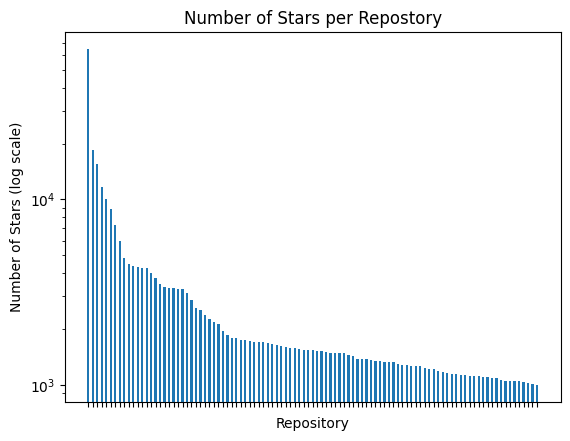

Number of repositories with 1000+ stars: 3423


In [13]:
# Plot the distribution of repositories by stars
repos = [x['name'] for x in sorted_repos_after_cutoff]
stars = [x['stars'] for x in sorted_repos_after_cutoff]

fig, ax = plt.subplots()
ax.bar(repos, stars, width=0.5)

ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.set(yscale='log')

ax.set_xlabel('Repository')
ax.set_ylabel('Number of Stars (log scale)')
ax.set_title('Number of Stars per Repostory')

plt.show()
print("Number of repositories with 1000+ stars:", len(repos_by_stars))

In [14]:
# To decide on bin number I used the Anderson-Darling test to check
# how normally distributed the data is.

# Perform the Anderson-Darling test
result = anderson(stars)

print('Anderson-Darling test statistic: %.3f' % result.statistic)
print('Critical values (significance levels):')
for i, crit_val in enumerate(result.critical_values):
    print('%.2f: %.3f' % ((i+1)/len(result.critical_values), crit_val))

# Interpret the results
if result.statistic > result.critical_values[2]:
    print('The data is not normally distributed at the 95% significance level.')
else:
    print('The data is normally distributed at the 95% significance level.')

print(result.statistic)
print(result.critical_values[2])

Anderson-Darling test statistic: 23.507
Critical values (significance levels):
0.20: 0.556
0.40: 0.633
0.60: 0.759
0.80: 0.885
1.00: 1.053
The data is not normally distributed at the 95% significance level.
23.506825328993287
0.759


Bin 1 value range: [1000.00, 5904.00]
Bin 2 value range: [5904.00, 10808.00]
Bin 3 value range: [10808.00, 15711.00]
Bin 4 value range: [15711.00, 20615.00]
Bin 5 value range: [20615.00, 25519.00]
Bin 6 value range: [25519.00, 30423.00]
Bin 7 value range: [30423.00, 35326.00]
Bin 8 value range: [35326.00, 40230.00]
Bin 9 value range: [40230.00, 45134.00]
Bin 10 value range: [45134.00, 50038.00]
Bin 11 value range: [50038.00, 54941.00]
Bin 12 value range: [54941.00, 59845.00]
Bin 13 value range: [59845.00, 64749.00]


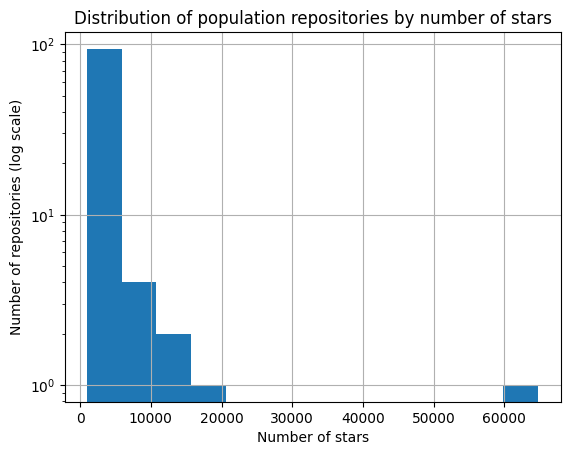

In [25]:
# Calculate the optimal number of bins using the Doane rule -
# which is good for non-normally distributed data.
# Also bin number isnt too high so not many empty bins
values = stars
bin_edges = np.histogram_bin_edges(values, bins='doane')

#Round to nearest int
bin_edges = np.round(bin_edges).astype(int)

# Calculate the histogram
hist, _ = np.histogram(values, bins=bin_edges)

# Print the value ranges of each bin
for i in range(len(bin_edges)-1):
    print(f"Bin {i+1} value range: [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]")

# Plot the histogram
import matplotlib.pyplot as plt

plt.hist(values, bins=bin_edges)

# Label the axes
plt.xlabel('Number of stars')
plt.ylabel('Number of repositories (log scale)')
plt.title('Distribution of population repositories by number of stars')
plt.yscale('log')
plt.grid(True)

plt.savefig('../data/population_distribution_histogram.png')

plt.show()

In [24]:
population = len(stars)

# Confidence level of 90%
z_score = 1.645

# Margin of Error of 10%
e = 0.1

# Initial sample size calculation
n = ((z_score**2) * 0.5 * (1-0.5))/e**2
print(n)

# Sample size given population size
sample_size = math.ceil((population * n)/(population + n))

print("Representative Sample size: ", sample_size)

67.65062499999999
Representative Sample size:  41


In [27]:
# Calculate percentage of repositories in each bin
bin_ranges = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges)-1)]
range_counts = [0] * len(bin_ranges)

for count in stars:
    for i, (start, end) in enumerate(bin_ranges):
        if start <= count <= end:
            range_counts[i] += 1
            break
percentages = []          
total_prs = sum(range_counts)
for (start, end), count in zip(bin_ranges, range_counts):
    percentage = count / total_prs * 100
    percentages.append(percentage)
    print(f"The repository with {start}-{end} stars: {percentage:.2f}%")

percentages = [round(x, 2) for x in percentages]

The repository with 1000-5904 stars: 92.16%
The repository with 5904-10808 stars: 3.92%
The repository with 10808-15711 stars: 1.96%
The repository with 15711-20615 stars: 0.98%
The repository with 20615-25519 stars: 0.00%
The repository with 25519-30423 stars: 0.00%
The repository with 30423-35326 stars: 0.00%
The repository with 35326-40230 stars: 0.00%
The repository with 40230-45134 stars: 0.00%
The repository with 45134-50038 stars: 0.00%
The repository with 50038-54941 stars: 0.00%
The repository with 54941-59845 stars: 0.00%
The repository with 59845-64749 stars: 0.98%


In [73]:
# Calculate the frequencies
frequencies = [round(p * sample_size / 100) for p in percentages]

# Sample the repo names for each star range
sampled_repos = []
for freq, (min_stars, max_stars) in zip(frequencies, bin_ranges):
    prs_in_range = [repos[i] for i in range(len(repos)) if min_stars <= stars[i] <= max_stars]
    if len(prs_in_range) < freq:
        # Not enough repos in range, add all of them
        sampled_repos.extend(prs_in_range)
    else:
        # Enough repos in range, sample randomly
        sampled_repos.extend(random.sample(prs_in_range, freq))

# Shuffle the repo names to mix up the star ranges
random.shuffle(sampled_repos)


In [74]:
print(sampled_repos)

# Get the number of commits for each sampled repository
commit_counts = 0
for repo in list_of_repos:
    if repo['name'] in sampled_repos:
        commit_counts += repo['commitCount']
        # print(f"Reporitory: {repo['name']}, Commits: {repo['commitCount']}, Url: {repo['url']}")

print(f"Total commits: {commit_counts}")

['PandoraNext-TokensTool', 'LakeSoul', 'aurora', 'super-xray', 'pkl', 'sql-father-backend-public', 'planetiler', 'Iconify', 'twoyi', 'incubator-paimon', 'FoxMagiskModuleManager', 'esProc', 'SpringBootExploit', 'xpipe', 'Grasscutter', 'hertzbeat', 'LiTiaotiao-Custom-Rules', 'chatgpt-java', 'paicoding', 'A-tutorial-compiler-written-in-Java', 'Cemiuiler', 'pinduoduo_backdoor_unpacker', 'Q-calculator', 'HummerRisk', 'incubator-fury', 'HyperCeiler', 'AntiAntiDefraud', 'langchain4j', 'wsMemShell', 'AgileBoot-Back-End', 'dingdong-helper', 'XQuickEnergy', 'chatgpt-java', 'Logout4Shell', 'Wukong_nocode', 'mybatis-flex', 'HeliBoard', 'spring-startup-analyzer', '1brc', 'oms-erp', 'MineDojo']
Total commits: 33333


In [78]:
# Generate a json with all sampled repositories
sampled_repos_dict = {}
for repo in list_of_repos:
    if repo['name'] in sampled_repos:
        sampled_repos_dict[repo['name']] = repo

if not os.path.exists('../data/evaluate_repositories.json'):
    with open('../data/evaluate_repositories.json', 'w') as json_file:
        json.dump(sampled_repos_dict, json_file, indent=4)
    print("File with sampled repositories created")


In [10]:
print(sampled_repos)

# Get the number of commits for each sampled repository
commit_counts = 0
for repo in list_of_repos:
    if repo['name'] in sampled_repos:
        commit_counts += repo['commitCount']
        print(f"Repository: {repo['name']}, Commits: {repo['commitCount']}, Url: {repo['url']}")

print(f"Total commits: {commit_counts}")

['PandoraNext-TokensTool', 'LakeSoul', 'aurora', 'super-xray', 'pkl', 'sql-father-backend-public', 'planetiler', 'Iconify', 'twoyi', 'incubator-paimon', 'FoxMagiskModuleManager', 'esProc', 'SpringBootExploit', 'xpipe', 'Grasscutter', 'hertzbeat', 'LiTiaotiao-Custom-Rules', 'chatgpt-java', 'paicoding', 'A-tutorial-compiler-written-in-Java', 'Cemiuiler', 'pinduoduo_backdoor_unpacker', 'Q-calculator', 'HummerRisk', 'incubator-fury', 'HyperCeiler', 'AntiAntiDefraud', 'langchain4j', 'wsMemShell', 'AgileBoot-Back-End', 'dingdong-helper', 'XQuickEnergy', 'chatgpt-java', 'Logout4Shell', 'Wukong_nocode', 'mybatis-flex', 'HeliBoard', 'spring-startup-analyzer', '1brc', 'oms-erp', 'MineDojo']
Reporitory: AntiAntiDefraud, Commits: 1, Url: https://github.com/MinaMichita/AntiAntiDefraud.git
Reporitory: HeliBoard, Commits: 1288, Url: https://github.com/Helium314/HeliBoard.git
Reporitory: XQuickEnergy, Commits: 100, Url: https://github.com/constanline/XQuickEnergy.git
Reporitory: planetiler, Commits: 8

In [ ]:
# sampled repos used for the evaluation
sampled_repos = ['PandoraNext-TokensTool', 'LakeSoul', 'aurora', 'super-xray', 'pkl', 'sql-father-backend-public', 'planetiler', 'Iconify', 'twoyi', 'incubator-paimon', 'FoxMagiskModuleManager', 'esProc', 'SpringBootExploit', 'xpipe', 'Grasscutter', 'hertzbeat', 'LiTiaotiao-Custom-Rules', 'chatgpt-java', 'paicoding', 'A-tutorial-compiler-written-in-Java', 'Cemiuiler', 'pinduoduo_backdoor_unpacker', 'Q-calculator', 'HummerRisk', 'incubator-fury', 'HyperCeiler', 'AntiAntiDefraud', 'langchain4j', 'wsMemShell', 'AgileBoot-Back-End', 'dingdong-helper', 'XQuickEnergy', 'chatgpt-java', 'Logout4Shell', 'Wukong_nocode', 'mybatis-flex', 'HeliBoard', 'spring-startup-analyzer', '1brc', 'oms-erp', 'MineDojo']

In [18]:
# Get the number of stars for each sampled repository
sampled_repos_stars = []
for repo in list_of_repos:
    if repo['name'] in sampled_repos:
        sampled_repos_stars.append(repo['stars'])
        #print(f"Reporitory: {repo['name']}, Stars: {repo['stars']}, Url: {repo['url']}")

print(f"Sampled repo stars: {sampled_repos_stars}")

Sampled repo stars: [1010, 1045, 1048, 1108, 1113, 1123, 1143, 1147, 1155, 1168, 1263, 1280, 1323, 1344, 1362, 1386, 1436, 1480, 1516, 1539, 1543, 1551, 1627, 1688, 1706, 1713, 1726, 1854, 2136, 2172, 2275, 2533, 3002, 3329, 3517, 4258, 4312, 4393, 8835, 10095, 15459]


Bin 1 value range: [1000.00, 5904.00]
Bin 2 value range: [5904.00, 10808.00]
Bin 3 value range: [10808.00, 15711.00]
Bin 4 value range: [15711.00, 20615.00]
Bin 5 value range: [20615.00, 25519.00]
Bin 6 value range: [25519.00, 30423.00]
Bin 7 value range: [30423.00, 35326.00]
Bin 8 value range: [35326.00, 40230.00]
Bin 9 value range: [40230.00, 45134.00]
Bin 10 value range: [45134.00, 50038.00]
Bin 11 value range: [50038.00, 54941.00]
Bin 12 value range: [54941.00, 59845.00]
Bin 13 value range: [59845.00, 64749.00]


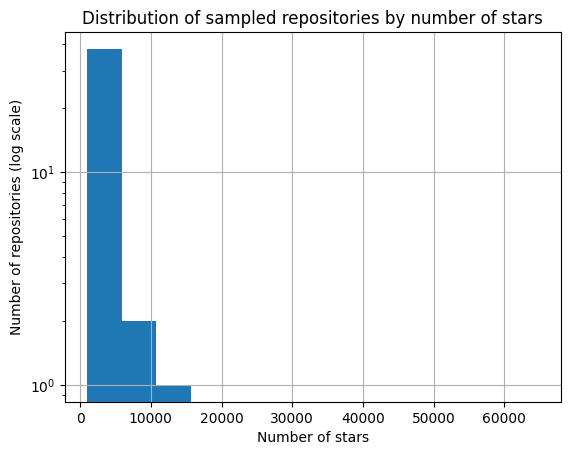

In [26]:
# get the distribution of the number of commits in the sampled repositories

values = sampled_repos_stars

#Round to nearest int
bin_edges = np.round(bin_edges).astype(int)

# Calculate the histogram
hist, _ = np.histogram(values, bins=bin_edges)

# Print the value ranges of each bin
for i in range(len(bin_edges)-1):
    print(f"Bin {i+1} value range: [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]")

# Plot the histogram
import matplotlib.pyplot as plt

plt.hist(values, bins=bin_edges)

# Label the axes
plt.xlabel('Number of stars')
plt.ylabel('Number of repositories (log scale)')
plt.title('Distribution of sampled repositories by number of stars')
plt.yscale('log')
plt.grid(True)
plt.savefig('../data/sample_distribution_histogram.png')

plt.show()
